In [0]:
# import standard python libraries
import os
from datetime import datetime
import numpy as np
import pandas as pd


# import the PyTorch deep learning libary
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils import data

# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# import tensorflow
import tensorflow as tf
import timeit



%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory

#Data Preperation

In [0]:
# download the Fashion MNIST training data
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)

# download the Fashion MNIST evaluation data
eval_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
train_images = train_dataset.data.numpy().reshape(-1,28*28)
train_labels = train_dataset.targets.data.numpy()

tensor_train_images = torch.Tensor(train_images)
tensor_train_labels = torch.Tensor(train_labels)

reshaped_train_dataset = data.TensorDataset(tensor_train_images, tensor_train_labels)

eval_images = eval_dataset.data.numpy().reshape(-1,28*28)
eval_labels = eval_dataset.targets.data.numpy()

tensor_eval_images = torch.Tensor(eval_images)
tensor_eval_labels = torch.Tensor(eval_labels)

reshaped_eval_dataset = data.TensorDataset(tensor_eval_images, tensor_eval_labels)

eval_dataloader = torch.utils.data.DataLoader(reshaped_eval_dataset, batch_size=32, shuffle=True)

#Testing if GPU is configured

In [0]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.9985138949996326
GPU (s):
0.19014235800023016
GPU speedup over CPU: 10x


In [0]:
# set gpu enabled flag
use_gpu = True

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

In [0]:
!nvidia-smi

Thu May 14 13:37:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    33W / 250W |   2055MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#Neural Network 1

In [0]:
# implement the MNISTNet network architecture
class MNISTNet1(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        # call super class constructor
        super(MNISTNet1, self).__init__()
        
        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear1 = nn.Linear(28*28, 300, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # specify fc layer 2 - in 300, out 150
        self.linear2 = nn.Linear(300, 150, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 150, out 50
        self.linear3 = nn.Linear(150, 50) # the linearity W*x+b
        self.relu3 = nn.ReLU(inplace=True) # the non-linarity
        
        # This may be working better

        # # specify fc layer 2 - in 300, out 150
        # self.linear2 = nn.Linear(300, 100, bias=True) # the linearity W*x+b
        # self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # # specify fc layer 3 - in 150, out 50
        # self.linear3 = nn.Linear(100, 50) # the linearity W*x+b
        # self.relu3 = nn.ReLU(inplace=True) # the non-linarity

        # specify fc layer 3 - in 50, out 10
        self.linear4 = nn.Linear(50, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        x = images.view(-1, 28*28)
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))

        # define fc layer 3 forward pass
        x = self.relu3(self.linear3(x))
        
        # define layer 4 forward pass
        x = self.logsoftmax(self.linear4(x))
        
        # return forward pass result
        return x

In [0]:
model = MNISTNet1()

In [0]:
# case: gpu computing enabled
if use_gpu == True:
  
  # push model to the GPU
  model = model.cuda()

In [0]:
# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(model))

[LOG] MNISTNet architecture:

MNISTNet1(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=150, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=150, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)



In [0]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained MNISTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained MNISTNet model parameters: 288710.


In [0]:
nll_loss = nn.NLLLoss()

# case: gpu computing enabled
if use_gpu == True:
  
  # push the loss calculation to the GPU
  nll_loss = nll_loss.cuda()

In [0]:
# specify the training parameters
num_epochs = 50 # number of training epochs
mini_batch_size = 32 # size of the mini-batches

# define learning rate and optimization strategy
learning_rate = 0.001
decay_rate = 0.01
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay = decay_rate)

In [0]:
train_dataloader = torch.utils.data.DataLoader(reshaped_train_dataset, batch_size=mini_batch_size, shuffle=True)

In [0]:
# init collection of training epoch losses
train_epoch_losses = []

# Record the epoch with lowest loss
best_epoch_nn1 = [-1,1]

# set the model in training mode
model.train()

# train the MNISTNet model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_dataloader):
        
        # case: gpu computing enabled
        if use_gpu == True:

          # convert images and labels to cuda tensor
          images = images.cuda()
          labels = labels.cuda()
        
        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()

        # determine classification loss
        loss = nll_loss(output, labels.long())
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    if train_epoch_loss < best_epoch_nn1[1]:
      best_epoch_nn1 = [epoch,train_epoch_loss]
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # save model to local directory
    model_name = 'model1_epoch_{}.pth'.format(str(epoch))
    torch.save(model.state_dict(), os.path.join("./models", model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20200514-13:37:25] epoch: 0 train-loss: 0.5615694558779398
[LOG 20200514-13:37:30] epoch: 1 train-loss: 0.4077398015499115
[LOG 20200514-13:37:35] epoch: 2 train-loss: 0.3688522709290187
[LOG 20200514-13:37:39] epoch: 3 train-loss: 0.3449074951728185
[LOG 20200514-13:37:44] epoch: 4 train-loss: 0.3271886687239011
[LOG 20200514-13:37:49] epoch: 5 train-loss: 0.31243323174119
[LOG 20200514-13:37:54] epoch: 6 train-loss: 0.3001013285835584
[LOG 20200514-13:37:58] epoch: 7 train-loss: 0.28976738791068396
[LOG 20200514-13:38:03] epoch: 8 train-loss: 0.28109608166217803
[LOG 20200514-13:38:08] epoch: 9 train-loss: 0.27387281496127447
[LOG 20200514-13:38:13] epoch: 10 train-loss: 0.2657046076933543
[LOG 20200514-13:38:17] epoch: 11 train-loss: 0.25798104224999746
[LOG 20200514-13:38:22] epoch: 12 train-loss: 0.25356802512804666
[LOG 20200514-13:38:27] epoch: 13 train-loss: 0.2473581052740415
[LOG 20200514-13:38:31] epoch: 14 train-loss: 0.24170843844016393
[LOG 20200514-13:38:36] epoch: 

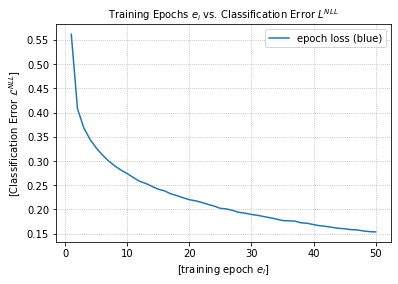

In [0]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

##Load Best model NN 1

In [0]:
# restore pre-trained model snapshot
best_model_name = "model1_epoch_{}.pth".format(best_epoch_nn1[0])

# init pre-trained model class
best_model = MNISTNet1()

# load pre-trained models
best_model.load_state_dict(torch.load(os.path.join("models", best_model_name), map_location='cpu'))

<All keys matched successfully>

In [0]:
# set model in evaluation mode
best_model.eval()

MNISTNet1(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=150, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=150, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)

In [0]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(eval_dataloader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = nll_loss(output, labels.long())

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20200514-13:41:18] eval-loss: 0.3504590392112732


In [0]:
predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)

In [0]:
metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach())

0.8886

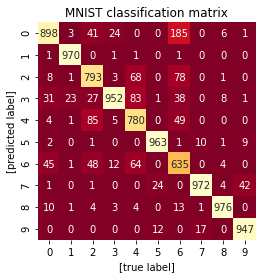

In [0]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(reshaped_eval_dataset.tensors[1], predictions.detach())

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=range(0,10), yticklabels=range(0,10))
plt.title('MNIST classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

In [0]:
# restore pre-trained model snapshot
best_model_numbers = list(range(0,num_epochs,10))

test_results_1 = []

for best_model_number in best_model_numbers:

  temp_results = [best_model_number]

  # init pre-trained model class
  best_model = MNISTNet1()

  # load pre-trained models
  best_model.load_state_dict(torch.load(os.path.join("models", "model1_epoch_{}.pth".format(best_model_number)), map_location='cpu'))

  # init collection of mini-batch losses
  eval_mini_batch_losses = []

  # iterate over all-mini batches
  for i, (images, labels) in enumerate(eval_dataloader):

      # run forward pass through the network
      output = best_model(images)

      # determine classification loss
      loss = nll_loss(output, labels.long())

      # collect mini-batch reconstruction loss
      eval_mini_batch_losses.append(loss.data.item())

  # determine mean min-batch loss of epoch
  eval_loss = np.mean(eval_mini_batch_losses)

  temp_results.append(eval_loss)

  predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)

  temp_results.append(metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach()))

  test_results_1.append(temp_results)
  

#Result of NN1

In [0]:
for test_result in test_results_1:
  print("Epoch {}: Loss = {} and Accuracy = {}".format(test_result[0],test_result[1], test_result[2]))

Epoch 0: Loss = 0.4845375418663025 and Accuracy = 0.8295
Epoch 10: Loss = 0.34154999256134033 and Accuracy = 0.876
Epoch 20: Loss = 0.33625999093055725 and Accuracy = 0.8802
Epoch 30: Loss = 0.31448546051979065 and Accuracy = 0.8884
Epoch 40: Loss = 0.33237436413764954 and Accuracy = 0.8871


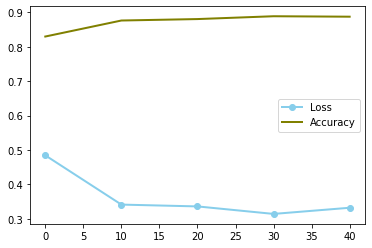

In [0]:
test_results_1 = pd.DataFrame(test_results_1)
# multiple line plot
plt.plot( test_results_1.iloc[:,0], test_results_1.iloc[:,1], marker='o', color='skyblue', linewidth=2,label="Loss")
plt.plot( test_results_1.iloc[:,0], test_results_1.iloc[:,2], marker='', color='olive', linewidth=2, label="Accuracy")
plt.legend()


#Neural Network 2

In [0]:
# implement the MNISTNet network architecture
class MNISTNet2(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        # call super class constructor
        super(MNISTNet2, self).__init__()
        
        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear1 = nn.Linear(28*28, 300, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # specify fc layer 2 - in 300, out 150
        self.linear2 = nn.Linear(300, 150, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 100, out 50
        self.linear3 = nn.Linear(150, 50) # the linearity W*x+b
        self.relu3 = nn.ReLU(inplace=True) # the non-linarity

        # specify fc layer 3 - in 50, out 10
        self.linear4 = nn.Linear(50, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        x = images.view(-1, 28*28)
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))

        # define fc layer 3 forward pass
        x = self.relu3(self.linear3(x))
        
        # define layer 4 forward pass
        x = self.logsoftmax(self.linear4(x))
        
        # return forward pass result
        return x

In [0]:
model = MNISTNet2()

In [0]:
# case: gpu computing enabled
if use_gpu == True:
  
  # push model to the GPU
  model = model.cuda()

In [0]:
# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(model))

[LOG] MNISTNet architecture:

MNISTNet2(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=150, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=150, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)



In [0]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained MNISTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained MNISTNet model parameters: 288710.


In [0]:
# define the optimization criterion / loss function
crossen_loss = nn.CrossEntropyLoss()

In [0]:
# case: gpu computing enabled
if use_gpu == True:
  
  # push the loss calculation to the GPU
  crossen_loss = crossen_loss.cuda()

In [0]:
# specify the training parameters
num_epochs = 50 # number of training epochs
mini_batch_size = 32 # size of the mini-batches

# define learning rate and optimization strategy
learning_rate = 0.001
decay_rate = 0.01
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay = decay_rate)

In [0]:
train_dataloader = torch.utils.data.DataLoader(reshaped_train_dataset, batch_size=mini_batch_size, shuffle=True)

In [0]:
# init collection of training epoch losses
train_epoch_losses = []

best_epoch_nn2 = [-1,1]

# set the model in training mode
model.train()

# train the MNISTNet model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_dataloader):
        
        # case: gpu computing enabled
        if use_gpu == True:

          # convert images and labels to cuda tensor
          images = images.cuda()
          labels = labels.cuda()
        
        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()
        # print(labels)
        # print(type(labels))
        # determine classification loss
        loss = crossen_loss(output, labels.long())
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    if train_epoch_loss < best_epoch_nn2[1]:
      best_epoch_nn2 = [epoch,train_epoch_loss]
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # save model to local directory
    model_name = 'model2_epoch_{}.pth'.format(str(epoch))
    torch.save(model.state_dict(), os.path.join("./models", model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20200514-13:41:25] epoch: 0 train-loss: 0.5709038093407949
[LOG 20200514-13:41:30] epoch: 1 train-loss: 0.40845763054291406
[LOG 20200514-13:41:35] epoch: 2 train-loss: 0.3671087781627973
[LOG 20200514-13:41:40] epoch: 3 train-loss: 0.3421915902535121
[LOG 20200514-13:41:45] epoch: 4 train-loss: 0.32380415516098343
[LOG 20200514-13:41:50] epoch: 5 train-loss: 0.30907065538764
[LOG 20200514-13:41:55] epoch: 6 train-loss: 0.2977730815112591
[LOG 20200514-13:42:00] epoch: 7 train-loss: 0.2874194360792637
[LOG 20200514-13:42:05] epoch: 8 train-loss: 0.27764162842035295
[LOG 20200514-13:42:10] epoch: 9 train-loss: 0.27042947650253774
[LOG 20200514-13:42:15] epoch: 10 train-loss: 0.2640569161688288
[LOG 20200514-13:42:20] epoch: 11 train-loss: 0.2564248181283474
[LOG 20200514-13:42:25] epoch: 12 train-loss: 0.2512848510811726
[LOG 20200514-13:42:29] epoch: 13 train-loss: 0.24569249513546626
[LOG 20200514-13:42:34] epoch: 14 train-loss: 0.24168651949763298
[LOG 20200514-13:42:39] epoch: 

In [0]:
# restore pre-trained model snapshot
best_model_numbers = list(range(0,num_epochs,10))

test_results_2 = []

for best_model_number in best_model_numbers:

  temp_results = [best_model_number]

  # init pre-trained model class
  best_model = MNISTNet2()

  # load pre-trained models
  best_model.load_state_dict(torch.load(os.path.join("models", "model2_epoch_{}.pth".format(best_model_number)), map_location='cpu'))

  # init collection of mini-batch losses
  eval_mini_batch_losses = []

  # iterate over all-mini batches
  for i, (images, labels) in enumerate(eval_dataloader):

      # run forward pass through the network
      output = best_model(images)

      # determine classification loss
      loss = crossen_loss(output, labels.long())

      # collect mini-batch reconstruction loss
      eval_mini_batch_losses.append(loss.data.item())

  # determine mean min-batch loss of epoch
  eval_loss = np.mean(eval_mini_batch_losses)

  temp_results.append(eval_loss)

  predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)

  temp_results.append(metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach()))

  test_results_2.append(temp_results)
  

# Result of NN2

In [0]:
for test_result in test_results_2:
  print("Epoch {}: Loss = {} and Accuracy = {}".format(test_result[0],test_result[1], test_result[2]))

Epoch 0: Loss = 0.486787348985672 and Accuracy = 0.8263
Epoch 10: Loss = 0.33580297231674194 and Accuracy = 0.8812
Epoch 20: Loss = 0.3264772295951843 and Accuracy = 0.8859
Epoch 30: Loss = 0.3267242908477783 and Accuracy = 0.8832
Epoch 40: Loss = 0.3178909420967102 and Accuracy = 0.889


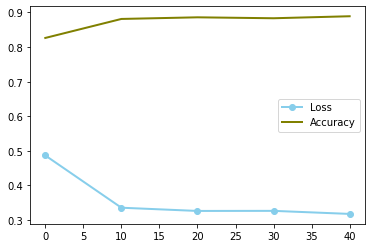

In [0]:
test_results_2 = pd.DataFrame(test_results_2)
# multiple line plot
plt.plot( test_results_2.iloc[:,0], test_results_2.iloc[:,1], marker='o', color='skyblue', linewidth=2,label="Loss")
plt.plot( test_results_2.iloc[:,0], test_results_2.iloc[:,2], marker='', color='olive', linewidth=2, label="Accuracy")
plt.legend()


# Comparing NN1 and NN2

In [0]:
for test_result in range(len(test_results_1)):
  print("At Epoch {} - NLL Accuracy = {} , Cross-Entropy = {}".format(test_results_1.iloc[test_result,0],test_results_1.iloc[test_result,2], test_results_2.iloc[test_result,2]))

At Epoch 0 - NLL Accuracy = 0.8295 , Cross-Entropy = 0.8263
At Epoch 10 - NLL Accuracy = 0.876 , Cross-Entropy = 0.8812
At Epoch 20 - NLL Accuracy = 0.8802 , Cross-Entropy = 0.8859
At Epoch 30 - NLL Accuracy = 0.8884 , Cross-Entropy = 0.8832
At Epoch 40 - NLL Accuracy = 0.8871 , Cross-Entropy = 0.889


In [0]:
# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(MNISTNet1()))

# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(MNISTNet2()))

[LOG] MNISTNet architecture:

MNISTNet1(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=150, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=150, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)

[LOG] MNISTNet architecture:

MNISTNet2(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=150, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=150, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)



# Neural Network 3

In [0]:
# implement the MNISTNet network architecture
class MNISTNet3(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        # call super class constructor
        super(MNISTNet3, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Flatten()
        )

        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear1 = nn.Linear(14*14*16, 1000, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU() # the non-linearity 

        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear2 = nn.Linear(1000, 300, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU() # the non-linearity 
        
        # specify fc layer 2 - in 300, out 150
        self.linear3 = nn.Linear(300, 150, bias=True) # the linearity W*x+b
        self.relu3 = nn.ReLU() # the non-linarity
        
        # specify fc layer 3 - in 100, out 50
        self.linear4 = nn.Linear(150, 50) # the linearity W*x+b
        self.relu4 = nn.ReLU() # the non-linarity

        # specify fc layer 3 - in 50, out 10
        self.linear5 = nn.Linear(50, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        # x = images.view(-1, 28*28)
        x = images.view(-1, 1, 28, 28)

        x = self.layer1(x)
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))

        # define fc layer 3 forward pass
        x = self.relu3(self.linear3(x))

        # define fc layer 3 forward pass
        x = self.relu4(self.linear4(x))
        
        # define layer 4 forward pass
        x = self.logsoftmax(self.linear5(x))
        
        # return forward pass result
        return x

In [0]:
model = MNISTNet3()

In [0]:
# case: gpu computing enabled
if use_gpu == True:
  
  # push model to the GPU
  model = model.cuda()

In [0]:
# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(model))

[LOG] MNISTNet architecture:

MNISTNet3(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
  )
  (linear1): Linear(in_features=3136, out_features=1000, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=1000, out_features=300, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=300, out_features=150, bias=True)
  (relu3): ReLU()
  (linear4): Linear(in_features=150, out_features=50, bias=True)
  (relu4): ReLU()
  (linear5): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)



In [0]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained MNISTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained MNISTNet model parameters: 3495454.


In [0]:
# define the optimization criterion / loss function
crossen_loss = nn.CrossEntropyLoss()

In [0]:
# case: gpu computing enabled
if use_gpu == True:
  
  # push the loss calculation to the GPU
  crossen_loss = crossen_loss.cuda()

In [0]:
# specify the training parameters
num_epochs = 20 # number of training epochs
mini_batch_size = 32 # size of the mini-batches

# define learning rate and optimization strategy
learning_rate = 0.001
decay_rate = 0.01
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay = decay_rate)

In [0]:
train_dataloader = torch.utils.data.DataLoader(reshaped_train_dataset, batch_size=mini_batch_size, shuffle=True)

In [0]:
# init collection of training epoch losses
train_epoch_losses = []

best_epoch_nn2 = [-1,1]

# set the model in training mode
model.train()

# train the MNISTNet model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_dataloader):
        
        # case: gpu computing enabled
        if use_gpu == True:

          # convert images and labels to cuda tensor
          images = images.cuda()
          labels = labels.cuda()
        
        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()
        # print(labels)
        # print(type(labels))
        # determine classification loss
        loss = crossen_loss(output, labels.long())
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    if train_epoch_loss < best_epoch_nn2[1]:
      best_epoch_nn2 = [epoch,train_epoch_loss]
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # save model to local directory
    model_name = 'model3_epoch_{}.pth'.format(str(epoch))
    torch.save(model.state_dict(), os.path.join("./models", model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20200514-13:45:36] epoch: 0 train-loss: 0.6400219484011332
[LOG 20200514-13:45:44] epoch: 1 train-loss: 0.44510433013439177
[LOG 20200514-13:45:52] epoch: 2 train-loss: 0.3889310169498126
[LOG 20200514-13:46:00] epoch: 3 train-loss: 0.3581025837421417
[LOG 20200514-13:46:08] epoch: 4 train-loss: 0.3350327165683111
[LOG 20200514-13:46:16] epoch: 5 train-loss: 0.3183518548051516
[LOG 20200514-13:46:24] epoch: 6 train-loss: 0.3016744249910116
[LOG 20200514-13:46:32] epoch: 7 train-loss: 0.29202406625946364
[LOG 20200514-13:46:39] epoch: 8 train-loss: 0.2798497920691967
[LOG 20200514-13:46:47] epoch: 9 train-loss: 0.270767559393247
[LOG 20200514-13:46:55] epoch: 10 train-loss: 0.2621776452104251
[LOG 20200514-13:47:03] epoch: 11 train-loss: 0.2542319280137618
[LOG 20200514-13:47:11] epoch: 12 train-loss: 0.24765376119414964
[LOG 20200514-13:47:18] epoch: 13 train-loss: 0.24018813653190932
[LOG 20200514-13:47:26] epoch: 14 train-loss: 0.2341179366807143
[LOG 20200514-13:47:34] epoch: 1

In [0]:
# restore pre-trained model snapshot
best_model_numbers = list(range(0,num_epochs,10))

test_results_3 = []

for best_model_number in best_model_numbers:

  temp_results = [best_model_number]

  # init pre-trained model class
  best_model = MNISTNet3()

  # load pre-trained models
  best_model.load_state_dict(torch.load(os.path.join("models", "model3_epoch_{}.pth".format(best_model_number)), map_location='cpu'))

  # init collection of mini-batch losses
  eval_mini_batch_losses = []

  # iterate over all-mini batches
  for i, (images, labels) in enumerate(eval_dataloader):

      # run forward pass through the network
      output = best_model(images)

      # determine classification loss
      loss = crossen_loss(output, labels.long())

      # collect mini-batch reconstruction loss
      eval_mini_batch_losses.append(loss.data.item())

  # determine mean min-batch loss of epoch
  eval_loss = np.mean(eval_mini_batch_losses)

  temp_results.append(eval_loss)

  predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)

  temp_results.append(metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach()))

  test_results_3.append(temp_results)
  

In [0]:
for test_result in test_results_3:
  print("Epoch {}: Loss = {} and Accuracy = {}".format(test_result[0],test_result[1], test_result[2]))

Epoch 0: Loss = 0.48152613639831543 and Accuracy = 0.8318
Epoch 10: Loss = 0.3334749937057495 and Accuracy = 0.8815


Add regularization (E.g. dropout) <br>
Try different optimization algorithm
- L-BFGS
- Conjugate gradient<br>
Try Cross-entropy loss function
Try Leaky Relu
Look into dropout layer for regularization

# Deep CNN Model

In [0]:
# implement the MNISTNet network architecture
class MNISTNet4(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        # call super class constructor
        super(MNISTNet4, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)
        )

        self.convlayer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)
        )

        self.convlayer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
            # nn.MaxPool2d(2,stride=2)
        )

        self.convlayer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Flatten()
        )

        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear1 = nn.Linear(3*3*128, 256, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU() # the non-linearity 
        self.dropout1 = nn.Dropout2d(p=0.2)

        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear2 = nn.Linear(256, 256, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU() # the non-linearity 
        self.dropout2 = nn.Dropout2d(p=0.2)

        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear3 = nn.Linear(256, 128, bias=True) # the linearity W*x+b
        self.relu3 = nn.ReLU() # the non-linearity 
        self.dropout3 = nn.Dropout2d(p=0.2)
        
        # specify fc layer 2 - in 300, out 150
        self.linear4 = nn.Linear(128, 32, bias=True) # the linearity W*x+b
        self.relu4 = nn.ReLU() # the non-linearity

        # specify fc layer 2 - in 300, out 150
        self.linear5 = nn.Linear(32, 10, bias=True) # the linearity W*x+b
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        # x = images.view(-1, 28*28)
        x = images.view(-1, 1, 28, 28)

        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        
        # define fc layer 1 forward pass
        x = self.dropout1(self.relu1(self.linear1(x)))
        # define fc layer 2 forward pass
        x = self.dropout2(self.relu2(self.linear2(x)))
        # define fc layer 2 forward pass
        x = self.dropout3(self.relu3(self.linear3(x)))
        x = self.relu4(self.linear4(x))
        # define layer 4 forward pass
        x = self.logsoftmax(self.linear5(x))
  
        # return forward pass result
        return x

In [0]:
model = MNISTNet4()

# case: gpu computing enabled
if use_gpu == True:
  
  # push model to the GPU
  model = model.cuda()

In [0]:
# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(model))

[LOG] MNISTNet architecture:

MNISTNet4(
  (convlayer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (convlayer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten()
  )
  (linear1): Linear(in_features=1152, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (linear2): Linear(in_features=256, out_features=256, bias=Tru

In [0]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained MNISTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained MNISTNet model parameters: 657322.


In [0]:
# define the optimization criterion / loss function
crossen_loss = nn.CrossEntropyLoss()
# nll_loss = nn.NLLLoss()

# case: gpu computing enabled
if use_gpu == True:
  
  # push the loss calculation to the GPU
  # nll_loss = nll_loss.cuda()
  crossen_loss = crossen_loss.cuda()

In [0]:
# specify the training parameters
num_epochs = 200 # number of training epochs
mini_batch_size = 32 # size of the mini-batches

# define learning rate and optimization strategy
learning_rate = 0.0001
decay_rate = 0.01
optimizer = optim.Adam(params=model.parameters() , amsgrad=True, lr=learning_rate)
# optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay = decay_rate,momentum=0.9)
# optimizers = {"Adam" : optim.Adam(params=model.parameters(),lr=0.0005), "SGD_mom.9" : optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9), "SGD_mom.05" : optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.05), "LBFGS":optim.LBFGS(params=model.parameters())}

In [0]:
train_dataloader = torch.utils.data.DataLoader(reshaped_train_dataset, batch_size=mini_batch_size, shuffle=True)

In [0]:
%%time

# init collection of training epoch losses
train_epoch_losses = []

best_epoch_nn4 = [-1,1]

# set the model in training mode
model.train()

# train the MNISTNet model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_dataloader):
        
        # case: gpu computing enabled
        if use_gpu == True:

          # convert images and labels to cuda tensor
          images = images.cuda()
          labels = labels.cuda()
        
        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()

        # determine classification loss
        loss = crossen_loss(output, labels.long())
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    if train_epoch_loss < best_epoch_nn4[1]:
      best_epoch_nn4 = [epoch,train_epoch_loss]

    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # # save model to local directory
    model_name = 'model4_epoch_{}.pth'.format(str(epoch))
    torch.save(model.state_dict(), os.path.join("./models", model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20200515-02:43:45] epoch: 0 train-loss: 0.6432794485251109
[LOG 20200515-02:44:04] epoch: 1 train-loss: 0.360899356953303
[LOG 20200515-02:44:23] epoch: 2 train-loss: 0.2995416166365147
[LOG 20200515-02:44:42] epoch: 3 train-loss: 0.264366140906016
[LOG 20200515-02:45:01] epoch: 4 train-loss: 0.2377980885843436
[LOG 20200515-02:45:20] epoch: 5 train-loss: 0.2157444507241249
[LOG 20200515-02:45:39] epoch: 6 train-loss: 0.19928808263937633
[LOG 20200515-02:45:58] epoch: 7 train-loss: 0.18136261536677678
[LOG 20200515-02:46:17] epoch: 8 train-loss: 0.16929750977158547
[LOG 20200515-02:46:36] epoch: 9 train-loss: 0.1566073646426201
[LOG 20200515-02:46:55] epoch: 10 train-loss: 0.14249454979101817
[LOG 20200515-02:47:14] epoch: 11 train-loss: 0.13135830139319102
[LOG 20200515-02:47:33] epoch: 12 train-loss: 0.12140791788101196
[LOG 20200515-02:47:52] epoch: 13 train-loss: 0.11011674775679907
[LOG 20200515-02:48:11] epoch: 14 train-loss: 0.10074665674169858
[LOG 20200515-02:48:30] epoch

In [1]:
# restore pre-trained model snapshot
# best_model_name = "model4_epoch_{}.pth".format(best_epoch_nn4[0])
best_model_name = "model4_epoch_{}.pth".format(197)

# init pre-trained model class
best_model = MNISTNet4()

# case: gpu computing enabled
if use_gpu == True:
  
  # push model to the GPU
  model = model.cuda()

# load pre-trained models
best_model.load_state_dict(torch.load(os.path.join("models", best_model_name), map_location='cpu'))

# print("Epoch {} has been loaded".format(best_epoch_nn4[0]))

NameError: ignored

In [0]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(eval_dataloader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = crossen_loss(output, labels.long())

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20200515-04:07:46] eval-loss: 0.7642876505851746


In [0]:
# Adam with amsgrad 200 epoch W/ Additional Layer 32 (NLLLoss)
predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)
metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach())

0.9255

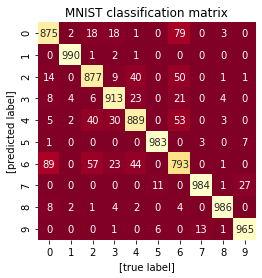

In [0]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(reshaped_eval_dataset.tensors[1], predictions.detach())

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=range(0,10), yticklabels=range(0,10))
plt.title('MNIST classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

In [0]:
# Adam with amsgrad 200 epoch W/ Additional Layer 32 (Cross Entropy)
predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)
metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach())

0.9265

In [0]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(reshaped_eval_dataset.tensors[1], predictions.detach())

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=range(0,10), yticklabels=range(0,10))
plt.title('MNIST classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

In [0]:
# Adam with amsgrad 100 epoch W/ Additional Layer
predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)
metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach())

0.9118

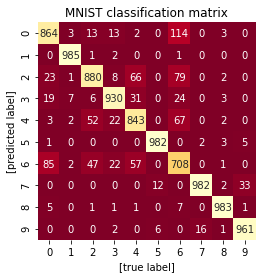

In [0]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(reshaped_eval_dataset.tensors[1], predictions.detach())

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=range(0,10), yticklabels=range(0,10))
plt.title('MNIST classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

In [0]:
# SGD Momentum 0.9 W/ Cross-Entropy
predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)
metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach())

0.8975

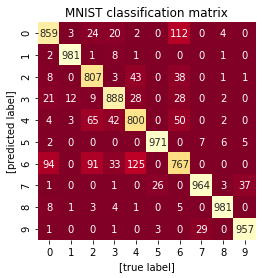

In [0]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(reshaped_eval_dataset.tensors[1], predictions.detach())

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=range(0,10), yticklabels=range(0,10))
plt.title('MNIST classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

In [0]:
# Adam W/ Cross-Entropy
predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)
metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach())

0.9068

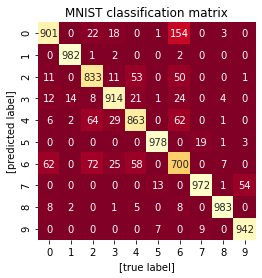

In [0]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(reshaped_eval_dataset.tensors[1], predictions.detach())

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=range(0,10), yticklabels=range(0,10))
plt.title('MNIST classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');